In [1]:
# KAGGLE
folder_path = '../input/lish-moa/'
# !cp '../input/custom-funcs-v2/bagging_funcs.py' .

In [2]:

'''ENSEMBLE NETS
Inspire by https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335'''

import numpy as np, pandas as pd, copy, tensorflow as tf, matplotlib.pyplot as plt, sklearn

from tensorflow import feature_column as fc
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import (Dense, DenseFeatures, Dropout, 
                                     BatchNormalization, Embedding, Input, Concatenate, Average,
                                     InputLayer, Lambda)
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras import backend as K, Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

import tensorflow_addons as tfa
from tensorflow_addons.layers import WeightNormalization

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

# from bagging_funcs import (DerivedFeatures, kfolds_bagging_training, voting_predict,
#                            kolds_stacked_ensemble_training, stacked_ensemble_predict )

import sys

def log_loss_metric(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred).numpy()

print(pd.__version__)
print(tf.__version__)
tf.python.client.device_lib.list_local_devices()


1.1.4
2.3.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10531739821430193582,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2997149427756443625
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15687541056
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12284566707609964448
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2447971705157806250
 physical_device_desc: "device: XLA_GPU device"]

In [3]:

# Loading data and encoding
raw_test = pd.read_csv(folder_path + 'test_features.csv')
raw_train = pd.read_csv(folder_path + 'train_features.csv')
raw_targets = pd.read_csv(folder_path + 'train_targets_scored.csv')
raw_nonscored = pd.read_csv(folder_path + 'train_targets_nonscored.csv')

# Phân loại dữ liệu
cols_id = ['sig_id']
cols_to_remove = ['cp_type']
cols_fts = [i for i in raw_train.columns if i not in cols_id +cols_to_remove]
cols_gene = [col for col in raw_train.columns if col.startswith("g-")]
cols_cell = [col for col in raw_train.columns if col.startswith("c-")]
cols_experiment = [col for col in cols_fts if col not in cols_gene+cols_cell]
cols_target = [i for i in raw_targets.columns if i not in cols_id]
num_fts, num_labels = len(cols_fts), len(cols_target)

# xử lý categorical
def transform_data(input_data):
    '''Clean data and encoding
        * input_data: table '''
    out = input_data.copy()
    out['cp_dose'] = out['cp_dose'].map({'D1':0, 'D2':1})
    out['cp_time'] = out['cp_time']/72
    
    return out

to_train = transform_data(raw_train[raw_train['cp_type'] != 'ctl_vehicle'])
to_train_targets = raw_targets.iloc[to_train.index]
full_pred  = transform_data(raw_test)
to_pred = full_pred[full_pred['cp_type'] != 'ctl_vehicle']

y_train = to_train_targets[cols_target].values
y_non_scored = raw_nonscored.iloc[to_train.index, 1:].values

In [4]:
# PARAMS
# u_fts_num = X_train.shape[1]
i_fts_num = num_labels

initializer = tf.keras.initializers.LecunNormal()# 'he_normal'  # <-- update
kn_reg = tf.keras.regularizers.l1(2e-7) # <-- update
activation = 'selu'  # <-- update
bias_init_carefully = tf.keras.initializers.Constant(np.log([16844/(21948*206 - 16844)]))


In [5]:
# Define model
def layer_BDWD( n_components, activation = 'relu',  kn_init = 'glorot_uniform', kn_reg = None, bias_init = None):
      def layer_cpl(input_layer):
        '''BN - DROPOUT - WEIGHTNORMAL - DENSE'''
        layer = BatchNormalization() (input_layer)
        layer = Dropout(0.25 ) (layer)
        dense = Dense(n_components, activation = activation, 
                      kernel_initializer = initializer, kernel_regularizer = kn_reg ,
                      bias_initializer = bias_init)
        layer = WeightNormalization(dense) (layer)
        return layer
      return layer_cpl
    
def layer_dense_set(hidden_list):
    def layer_cpl(input_layer):
        layer = input_layer
        for n_hid in hidden_list:
            layer = layer_BDWD(n_hid, activation = activation, kn_init = initializer, kn_reg = kn_reg, bias_init = bias_init_carefully) (layer)
        return layer
    return layer_cpl

# Model1 
def model1(n_input, n_output):
    input_u = Input(shape = (n_input,) )
    layer_u = layer_dense_set(hidden_list = [1024, 1024, 512]) (input_u)
    out_put = WeightNormalization(Dense(n_output, activation = 'sigmoid' ))(layer_u)
    model1 =  Model(inputs=[input_u, ], outputs= [out_put])
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)

    bce = tf.keras.losses.BinaryCrossentropy()
    model1.compile(loss= BinaryCrossentropy(), optimizer=opt , metrics= [bce])
    return model1

In [6]:
# CALLBACK
def exp_decay(lr0, s, down_hill):
    def exp_decay_fn(epoch):
        if epoch <= 5:
            out = lr0*2
        elif epoch%s <= 1:
            out = lr0
        else:
            out = lr0 + 0.015*(epoch%s/ (s - 1))* down_hill/ (down_hill + int(epoch/s) )
        return np.clip( out, 0.001, 0.05)
    return exp_decay_fn

fn_lr = exp_decay(0.001, 5, 50)
lr_schedule = tf.keras.callbacks.LearningRateScheduler ( fn_lr )

reduce_lr = ReduceLROnPlateau(monitor='val_binary_crossentropy', factor=0.1, patience=5, mode='min', min_lr=1E-5, verbose= 0)
early_stopping = EarlyStopping(monitor='val_binary_crossentropy', min_delta=0.5E-4, patience=15, mode='min',restore_best_weights=True, verbose= 0)

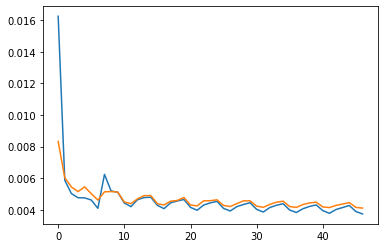

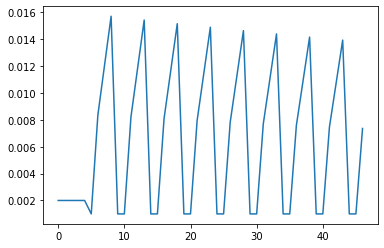

In [7]:
# Add nonscore fts   
model_nonscored_rep = model1(n_input = to_train[cols_fts].shape[1], n_output = y_non_scored.shape[1])
history = model_nonscored_rep.fit(
        to_train[cols_fts], y_non_scored, validation_split = 0.25, 
        callbacks=[early_stopping, lr_schedule], epochs= 47, verbose = 0,
        batch_size= 128)

# Graph___________________________________
hí = history.history
đầu_ra = {x: hí[x] for x in ['binary_crossentropy', 'val_binary_crossentropy']}
plt.plot(pd.DataFrame(đầu_ra))
plt.show()
lr = []
for i in range(47) :
    lr.append( fn_lr(i+1) )
plt.plot(np.array(lr))
plt.show()

In [8]:
# add_fts
X_train = np.concatenate([to_train[cols_fts].values, model_nonscored_rep.predict(to_train[cols_fts])], axis = 1)
X_pred = np.concatenate([to_pred[cols_fts].values, model_nonscored_rep.predict(to_pred[cols_fts])], axis = 1)

In [9]:
scaler = StandardScaler()
scaler.fit(np.concatenate([X_train, X_pred]))
X_train = scaler.transform(X_train)
X_pred = scaler.transform(X_pred)

In [10]:
# # Train 1st model

# model_mlp = model1(n_input = X_train.shape[1], n_output = y_train.shape[1])
# model_mlp_copy1 = tf.keras.models.clone_model(model_mlp)
# # Fitting
# history = model_mlp.fit(
#         X_train, y_train, validation_split = 0.25, 
#         callbacks=[early_stopping, lr_schedule], epochs= 72, verbose =1,
#         batch_size= 128)

# model_mlp_copy2 = tf.keras.models.clone_model(model_mlp)

# # Graph___________________________________
# hí = history.history
# đầu_ra = {x: hí[x] for x in ['binary_crossentropy', 'val_binary_crossentropy']}
# plt.plot(pd.DataFrame(đầu_ra))
# plt.show()
# lr = []
# for i in range(47) :
#     lr.append( fn_lr(i+1) )
# plt.plot(np.array(lr))
# plt.show()

In [11]:
# Log_loss return numpy values
def log_loss_metric(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred).numpy()

# Random bagging nets
def bagging_split(X_train, y_train, alpha, n_samples):
    ''' SPLIT TRAINING DATA TO N SAMPLES FOR BAGGING
    :X_train:np array: data for model training only
    :y_train:np array: labels for model training only
    :alpha:0-1 float: poportion of data in each sample
    return:
        generator for bagging training set'''
    data_length = X_train.shape[0]
    for i in range(n_samples):
        idx = np.random.choice( data_length, size= int(data_length * alpha), replace=0)
        yield X_train[idx], y_train[idx]

# Predict with average ouput from a list of models
def voting_predict(model_list, X_pred ):
    '''PREDICT OUTPUT FROM A LIST OF MODEL'''
    pred = 0
    for model in model_list:
        pred += model.predict(X_pred)
    avg_pred = pred/len(model_list)
    avg_pred[:,[34,82]] = 0
    return avg_pred

def reset_seed_model(model):
    seed = int( np.random.random() *100)
    np.random.seed(seed)
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    model_ = model1(n_input = X_train.shape[1], n_output = y_train.shape[1]) # <----- UPDATE THIS
    return model_

def bagging_training(model, X_train, y_train, X_val, y_val, alpha, n_samples, save_path = '', callbacks = [], epochs = 47, batch_size = 128):
    '''TRAINING FOR EACH BOOSTRAP AGGREGATING (BAGGING)
    return:
        list of n_samples model'''
    model_list = []

    for bag_id, (x_train_bag, y_train_bag) in enumerate(bagging_split(X_train, y_train, alpha = alpha, n_samples = n_samples)):
        model_ = reset_seed_model(model)
        model_.fit(
            x_train_bag, y_train_bag, validation_data = (X_val, y_val), 
            callbacks= callbacks , epochs= epochs, verbose = 0,
            batch_size= batch_size )
        
        y_pred_inbag = model_.predict(X_val)
        evaluate_at_bag = log_loss_metric(y_val, y_pred_inbag)
        print('Logloss at bag ', bag_id, ': ', evaluate_at_bag)
        model_list.append(model_)
        del model_
    
    print('Evaluate bagging, log loss = ', 
        log_loss_metric(y_val,  voting_predict(model_list, X_val )  ) )

    return model_list

def kfolds_bagging_training(NFOLDS, model, SEEDS, X_train, y_train, bagging_alpha = 0.75, bagging_samples = 10, callbacks = [], epochs = 47, batch_size = 128):
    ''' TRAINING FOR KFOLDS EVALUATION
    :NFOLDS:int: số folds
    :model:model: model dùng để train
    :SEEDS:list: list of seeds to train
    :X_train:np array: full data for train and evaluate
    :y_train:np array: full labels for train and evaluate
    return:
        :list of list model: list NFOLDS-list trained model
    '''
    ouput = []
    kf = KFold(n_splits= NFOLDS, shuffle = True)
    fold_logloss = []

    for fold_id, (train_index, val_index) in enumerate(kf.split(X_train)):
        print('Training at fold: ', fold_id, '-'*100)

        fold_X_train, fold_y_train = X_train[train_index], y_train[train_index]
        fold_X_val, fold_y_val = X_train[val_index], y_train[val_index]

        # Training bagging
        model_list = bagging_training(model, fold_X_train, fold_y_train, fold_X_val ,fold_y_val,
            alpha = bagging_alpha, n_samples = bagging_samples, callbacks = callbacks, epochs = epochs, batch_size = batch_size)

        fold_logloss.append( log_loss_metric(fold_y_val,  voting_predict( model_list, fold_X_val )) )
        ouput.append(model_list)
    
    print('AVG logloss all folds: ', np.mean(fold_logloss))

    return ouput

In [13]:
# BAGGING
model_2list = kfolds_bagging_training(7, 
                                      1
                                      , [], X_train, y_train, bagging_alpha = 0.75, bagging_samples = 8,  
                                      callbacks = [early_stopping, lr_schedule], 
                                      epochs = 72, batch_size = 128)

Training at fold:  0 ----------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
prediction = voting_predict( sum(model_2list, []), X_pred )
# prediction = model1.predict(X_pred)

df_preds_non_ctl =  pd.DataFrame(prediction, columns= cols_target, index = to_pred.index)

# concat with all to pred values
df_preds = pd.concat([ full_pred[cols_id], df_preds_non_ctl], axis = 1).fillna(0)
# to csv
df_preds.to_csv("submission.csv", index = None)

In [ ]:
df_preds